# Assign RegulatoryOverlayUUIDs Values to Water Right sites.csv
Purpose:  To assign RegulatoryOverlayUUIDs values to state water right sites.csv File.

Notes: 
- requires the completed pre-processed sites.csv & watersource.csv files from the state "WaterAllocation/ProcessedInputData" folder to be copied over to the "Regulatory/ProcessedInputData" folder.  Rename to wr_sites.csv & wr_watersource.csv to preserve inputs.
- requires awareness of unique WaterSourceTypeCV of each water right site match up to corresponding WaterSourceTypeCV of regulatoryoverlays per reportingunits

In [1]:
# Needed Libraries / Modules

# ---- working with data ----
import os  # native operating system interaction
import numpy as np  # mathematical array manipulation
import pandas as pd  # data structure and data analysis
import geopandas as gpd  # geo-data structure and data analysis

# ---- visualization ----
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # plotting library
import geoplot as gplt # for plotting mapsa
import geoplot.crs as gcrs #used to pull in webdata

# ---- API data retrieval ----
import requests  # http requests
import json  # JSON parse

# ---- Cleanup ----
import re  # string regular expression manipulation
from datetime import datetime  # date and time manipulation
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppress scientific notation in Pandas

In [2]:
# ---- working directory ----
workingDirString = "G:/Shared drives/WaDE Data/NewMexico/Regulatory" # set working directory folder string here
os.chdir(workingDirString)
print(f'The working Directory is:', workingDirString)

The working Directory is: G:/Shared drives/WaDE Data/NewMexico/Regulatory


## Input Data

In [3]:
# Regulatory Input Data
dfro = pd.read_csv("ProcessedInputData/regulatoryoverlays.csv")
dfru = pd.read_csv("ProcessedInputData/reportingunits.csv")
dfrru = pd.read_csv("ProcessedInputData/regulatoryreportingunits.csv")

# Water right Input Data
dfws = pd.read_csv('ProcessedInputData/wr_watersources.csv')
dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', engine = "python", error_bad_lines=False)

C:\Users\rjame\AppData\Local\Temp\ipykernel_6312\447271929.py:8: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', engine = "python", error_bad_lines=False)


In [4]:
#### regulatory watersource info with reporting unit info

# merge regulatoryoverlays -to- regulatoryreportingunits -to- reportingunits
dfro = pd.merge(dfro[['RegulatoryOverlayUUID', 'WaterSourceTypeCV']], dfrru[['RegulatoryOverlayUUID', 'ReportingUnitUUID']], left_on='RegulatoryOverlayUUID', right_on='RegulatoryOverlayUUID', how='left')
dfru = pd.merge(dfru, dfro, left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')

print(dfru['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfru))
dfru.head(1)

['Surface and Groundwater']
249


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,NMre_RU0SWCDb,4326,Border,0SWCDb,NaN,Soil Water Conservation District,NaN,NM,MULTIPOLYGON (((-103.63156317460079 33.6197811...,NMre_RO0SWCDb,Surface and Groundwater


In [5]:
#### water right watersource info with site info

# explode site.csv on WaterSourceUUIDs
dfs = dfs.assign(WaterSourceUUIDs=dfs['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)

# merge watersources to dfs via WaterSourceUUIDs -to -WaterSourceUUID
dfs = pd.merge(dfs, dfws[['WaterSourceUUID', 'WaterSourceTypeCV']], left_on='WaterSourceUUIDs', right_on='WaterSourceUUID', how='left')
print(dfs['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfs))
dfs.head(1)

['Groundwater' 'WaDE Blank' 'Surface and Groundwater' 'Surface Water']
265649


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,NMwr_SA00001,NaN,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,NaN,NaN,NaN,NaN,32.08853,-108.88052,NaN,NaN,POD,WaDE Blank,A-00001,NaN,WaDE Blank,NM,NaN,NMwr_WSwadeID1,Groundwater


## Extract RegulatoryOverlay from Reporting Units and assing to WR Sites
- repeat scripts based on the number of ReportingUnitTypeCV types.
- merge all geo-dataframes into one output

#### Regulatory Area Data #1

In [6]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru1 = dfru.copy()
nameOfReportingUnitTypeVar = "Water Right Regulations" # change here for ReportingUnitTypeCV of interest
dfru1 = dfru1[dfru1['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru1))
print(dfru1['WaterSourceTypeCV'].unique())
dfru1.head(1)

202
['Surface and Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
1,NMre_RU0WRRmss,4326,McGaffey Superfund Site,0WRRmss,NaN,Water Right Regulations,5/9/2016,NM,POLYGON ((-104.50837499899995 33.3833663910000...,NMre_RO0WRRmss,Surface and Groundwater


<GeoAxesSubplot: >

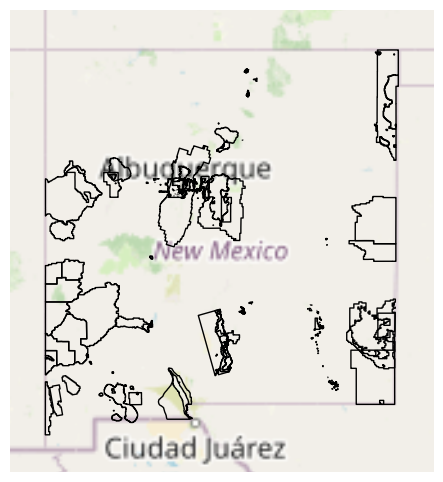

In [7]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru1 = dfru1[dfru1['Geometry'] != ""].reset_index(drop=True)
dfru1['Geometry'] = gpd.GeoSeries.from_wkt(dfru1['Geometry'], crs="EPSG:4326")
gdfru1 = gpd.GeoDataFrame(dfru1, geometry=dfru1['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru1, ax=ax)

In [8]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs1 = dfs.copy()
# nameOfWaterSourceTypeCV= "WaDE Blank" # change here for WaterSourceTypeCV of interest
#dfs1 = dfs1[dfs1['WaterSourceTypeCV'] != nameOfWaterSourceTypeCV] #making assumption that it applies to everywehre
dfs1 = dfs1[dfs1['PODorPOUSite'] == 'POD']
print(len(dfs1))
print(dfs1['WaterSourceTypeCV'].unique())
dfs1.head(1)

265649
['Groundwater' 'WaDE Blank' 'Surface and Groundwater' 'Surface Water']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,NMwr_SA00001,NaN,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,NaN,NaN,NaN,NaN,32.08853,-108.88052,NaN,NaN,POD,WaDE Blank,A-00001,NaN,WaDE Blank,NM,NaN,NMwr_WSwadeID1,Groundwater


<GeoAxesSubplot: >

C:\Users\rjame\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


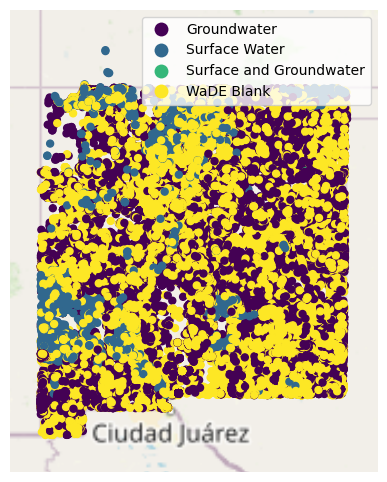

In [9]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs1 = gpd.GeoDataFrame(dfs1, geometry=gpd.points_from_xy(dfs1.Longitude.astype(float), dfs1.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [10]:
# Select sites within polygon.
gdfs1_ru1 = gpd.sjoin(left_df=gdfs1, right_df=gdfru1[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs1_ru1))
gdfs1_ru1.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


215398


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
0,NMwr_SA00001,,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.08853,-108.88052,,,POD,WaDE Blank,A-00001,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater,POINT (-108.88052 32.08853),152,NMre_RU55WRRac,NMre_RO55WRRac
1,NMwr_SA00001S,,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.08881,-108.88089,,,POD,WaDE Blank,A-00001-S,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater,POINT (-108.88089 32.08881),152,NMre_RU55WRRac,NMre_RO55WRRac
2,NMwr_SA00001S2,,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.08895,-108.88079,,,POD,WaDE Blank,A-00001-S2,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater,POINT (-108.88079 32.08895),152,NMre_RU55WRRac,NMre_RO55WRRac
3,NMwr_SA00002,,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.23971,-108.84578,,,POD,WaDE Blank,A-00002,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater,POINT (-108.84578 32.23971),152,NMre_RU55WRRac,NMre_RO55WRRac
4,NMwr_SA00002S,,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.23562,-108.84560,,,POD,WaDE Blank,A-00002-S,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater,POINT (-108.84560 32.23562),152,NMre_RU55WRRac,NMre_RO55WRRac


<GeoAxesSubplot: >

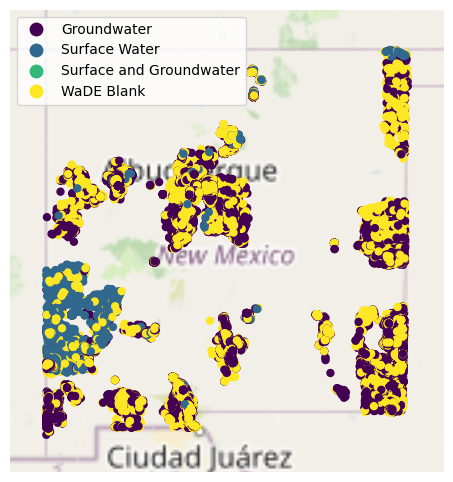

In [11]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs1_ru1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [12]:
# set RegulatoryOverlayUUIDs
gdfs1_ru1['RegulatoryOverlayUUIDs'] = gdfs1_ru1['RegulatoryOverlayUUID']
gdfs1_ru1 = gdfs1_ru1.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs1_ru1.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
0,NMwr_SA00001,NMre_RO55WRRac,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.08853,-108.88052,,,POD,WaDE Blank,A-00001,,WaDE Blank,NM,


#### Regulatory Area Data #2

In [13]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru2 = dfru.copy()
nameOfReportingUnitTypeVar = "Soil Water Conservation District" # change here for ReportingUnitTypeCV of interest
dfru2 = dfru2[dfru2['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru2))
print(dfru2['WaterSourceTypeCV'].unique())
dfru2.head(1)

47
['Surface and Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,NMre_RU0SWCDb,4326,Border,0SWCDb,NaN,Soil Water Conservation District,NaN,NM,MULTIPOLYGON (((-103.63156317460079 33.6197811...,NMre_RO0SWCDb,Surface and Groundwater


<GeoAxesSubplot: >

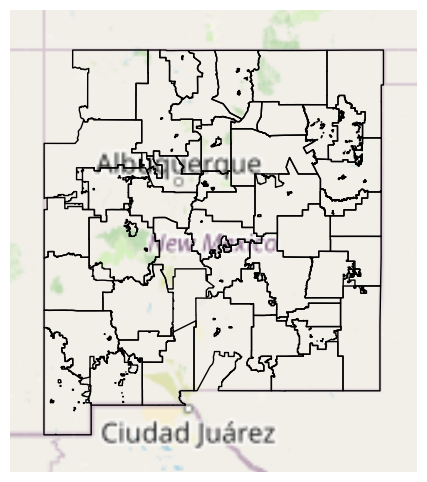

In [14]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru2 = dfru2[dfru2['Geometry'] != ""].reset_index(drop=True)
dfru2['Geometry'] = gpd.GeoSeries.from_wkt(dfru2['Geometry'], crs="EPSG:4326")
gdfru2 = gpd.GeoDataFrame(dfru2, geometry=dfru2['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru2, ax=ax)

In [15]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs2 = dfs.copy()
# nameOfWaterSourceTypeCV= "WaDE Blank" # change here for WaterSourceTypeCV of interest
#dfs2 = dfs2[dfs2['WaterSourceTypeCV'] != nameOfWaterSourceTypeCV] #making assumption that it applies to everywehre
dfs2 = dfs2[dfs2['PODorPOUSite'] == 'POD']
print(len(dfs2))
print(dfs2['WaterSourceTypeCV'].unique())
dfs2.head(1)

265649
['Groundwater' 'WaDE Blank' 'Surface and Groundwater' 'Surface Water']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,NMwr_SA00001,NaN,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,NaN,NaN,NaN,NaN,32.08853,-108.88052,NaN,NaN,POD,WaDE Blank,A-00001,NaN,WaDE Blank,NM,NaN,NMwr_WSwadeID1,Groundwater


<GeoAxesSubplot: >

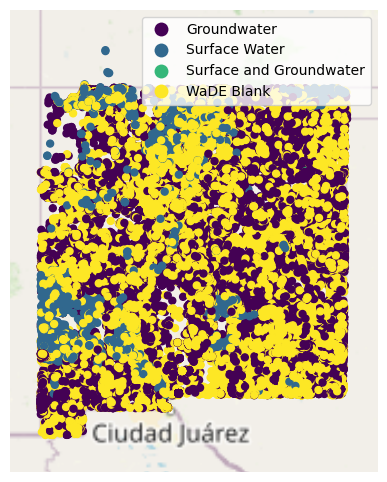

In [16]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs2 = gpd.GeoDataFrame(dfs2, geometry=gpd.points_from_xy(dfs2.Longitude.astype(float), dfs2.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs2, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [17]:
# Select sites within polygon.
gdfs2_ru2 = gpd.sjoin(left_df=gdfs2, right_df=gdfru2[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs2_ru2))
gdfs2_ru2.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


259125


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
0,NMwr_SA00001,,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.08853,-108.88052,,,POD,WaDE Blank,A-00001,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater,POINT (-108.88052 32.08853),39,NMre_RU45SWCDh,NMre_RO45SWCDh
1,NMwr_SA00001S,,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.08881,-108.88089,,,POD,WaDE Blank,A-00001-S,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater,POINT (-108.88089 32.08881),39,NMre_RU45SWCDh,NMre_RO45SWCDh
2,NMwr_SA00001S2,,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.08895,-108.88079,,,POD,WaDE Blank,A-00001-S2,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater,POINT (-108.88079 32.08895),39,NMre_RU45SWCDh,NMre_RO45SWCDh
3,NMwr_SA00002,,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.23971,-108.84578,,,POD,WaDE Blank,A-00002,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater,POINT (-108.84578 32.23971),39,NMre_RU45SWCDh,NMre_RO45SWCDh
4,NMwr_SA00002S,,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.23562,-108.84560,,,POD,WaDE Blank,A-00002-S,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater,POINT (-108.84560 32.23562),39,NMre_RU45SWCDh,NMre_RO45SWCDh


<GeoAxesSubplot: >

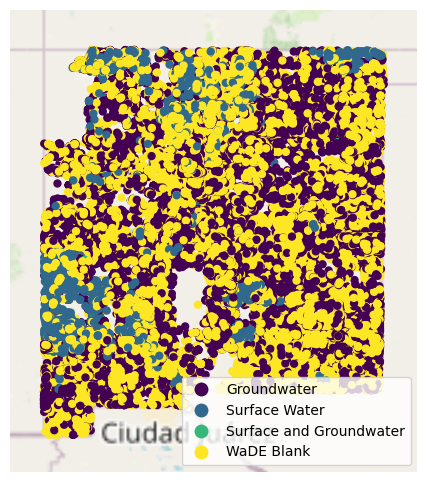

In [18]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs2_ru2, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [19]:
# set RegulatoryOverlayUUIDs
gdfs2_ru2['RegulatoryOverlayUUIDs'] = gdfs2_ru2['RegulatoryOverlayUUID']
gdfs2_ru2 = gdfs2_ru2.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs2_ru2.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
0,NMwr_SA00001,NMre_RO45SWCDh,NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.08853,-108.88052,,,POD,WaDE Blank,A-00001,,WaDE Blank,NM,


## Concatenate all Regulatory Area Data Types together
- drop geometry from the wade wr sites.csv geodataframe

In [20]:
# Concatenate dataframes into single output
frames = [dfs, gdfs1_ru1, gdfs2_ru2] # list all out dataframes here
outdfs = pd.concat(frames)
outdfs = outdfs.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
outdfs = outdfs.groupby('SiteUUID').agg(lambda x: ','.join([str(elem) for elem in (list(set(x))) if elem != ""])).replace(np.nan, "").reset_index()
print(len(outdfs))
outdfs.head(1)

265649


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,NMwr_SA00001,"NMre_RO55WRRac,NMre_RO45SWCDh",NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.08852543145729,-108.88051896223872,,,POD,WaDE Blank,A-00001,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater


# Inspect Output Data & Export

In [21]:
outdfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265649 entries, 0 to 265648
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   SiteUUID                265649 non-null  object
 1   RegulatoryOverlayUUIDs  265649 non-null  object
 2   WaterSourceUUIDs        265649 non-null  object
 3   CoordinateAccuracy      265649 non-null  object
 4   CoordinateMethodCV      265649 non-null  object
 5   County                  265649 non-null  object
 6   EPSGCodeCV              265649 non-null  object
 7   Geometry                265649 non-null  object
 8   GNISCodeCV              265649 non-null  object
 9   HUC12                   265649 non-null  object
 10  HUC8                    265649 non-null  object
 11  Latitude                265649 non-null  object
 12  Longitude               265649 non-null  object
 13  NHDNetworkStatusCV      265649 non-null  object
 14  NHDProductCV            265649 non-n

In [22]:
outdfs

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,NMwr_SA00001,"NMre_RO55WRRac,NMre_RO45SWCDh",NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.08852543145729,-108.88051896223872,,,POD,WaDE Blank,A-00001,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater
1,NMwr_SA00001S,"NMre_RO55WRRac,NMre_RO45SWCDh",NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.08880863623688,-108.88089406970218,,,POD,WaDE Blank,A-00001-S,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater
2,NMwr_SA00001S2,"NMre_RO55WRRac,NMre_RO45SWCDh",NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.08894715341991,-108.8807855981426,,,POD,WaDE Blank,A-00001-S2,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater
3,NMwr_SA00002,"NMre_RO55WRRac,NMre_RO45SWCDh",NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.23971296437374,-108.8457832111845,,,POD,WaDE Blank,A-00002,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater
4,NMwr_SA00002S,"NMre_RO55WRRac,NMre_RO45SWCDh",NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.23562412371736,-108.84559903738057,,,POD,WaDE Blank,A-00002-S,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265644,NMwr_SVV00198POD1,"NMre_RO37WRRgbr,NMre_RO45SWCDh",NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.69541658839018,-109.02172178459696,,,POD,WaDE Blank,VV-00198-POD1,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater
265645,NMwr_SVV00199POD1,"NMre_RO37WRRgbr,NMre_RO45SWCDh",NMwr_WSwadeID2,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.68716662119876,-108.99855516895518,,,POD,WaDE Blank,VV-00199-POD1,,WaDE Blank,NM,,NMwr_WSwadeID2,WaDE Blank
265646,NMwr_SVV00200POD1,"NMre_RO37WRRgbr,NMre_RO45SWCDh",NMwr_WSwadeID1,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.69444481184614,-109.03749974324502,,,POD,WaDE Blank,VV-00200-POD1,,WaDE Blank,NM,,NMwr_WSwadeID1,Groundwater
265647,NMwr_SVV00201POD1,"NMre_RO37WRRgbr,NMre_RO45SWCDh",NMwr_WSwadeID2,WaDE Blank,WaDE Blank,Hidalgo,4326,,,,,32.69353629696729,-109.0247385440764,,,POD,WaDE Blank,VV-00201-POD1,,WaDE Blank,NM,,NMwr_WSwadeID2,WaDE Blank


In [23]:
# Export out to CSV.
outdfs.to_csv('ProcessedInputData/sites.csv', index=False) # this is in the Regulatory data folder